# Installing and Importing required libraries

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 198 kB 55.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=fe7e848a0461effeba1bf0c9ce3209bb19dea61ac57d819358335d16fb6e6753
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

import pyspark
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession

In [ ]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark_sql = SparkSession.builder.getOrCreate()

# Data Extraction and Data Insights

In [ ]:
df = spark_sql.read.option('inferschema',"true").csv('/content/drive/MyDrive/my projects/credit card fraud detection/creditcard.csv',header=True)

In [ ]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [ ]:
df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|                V22|     

In [ ]:
df.count()

284807

In [ ]:
#this is used to convert a dataframe in to view which can be used to write and process sql query
df.createOrReplaceTempView("cc_df")

In [ ]:
# # To get number of nan value for each column
# for cur_column in df.columns:
#   t = spark_sql.sql(f"select count(*) as count_null from cc_df where {cur_column} is NULL").collect()[0][0]
#   print(f'{cur_column}    :   {t}')

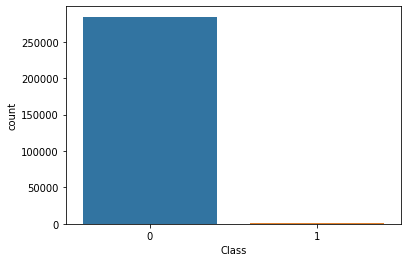

In [ ]:
sns.countplot(x='Class',data=df.toPandas())

data is very highly imbalanced
so before we make data balanced we will first remove the outliers from class '0' 😊

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


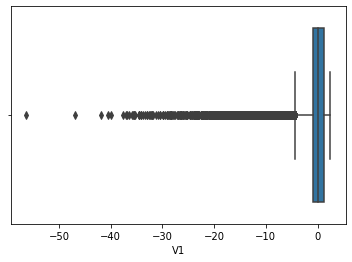

In [ ]:
sns.boxplot("V1",data=df.toPandas())

In [ ]:
limits = df.approxQuantile("V1",[0.25,0.75],0.1)
iqr = limits[-1] - limits[0]
upper_limit = limits[-1] + (1.5 * iqr)
lower_limit = limits[0] - (1.5 * iqr)

In [ ]:
features = df.columns
features.remove("Time")
features.remove("Class")

In [ ]:
updated_df = df
for feature in features:

  limits = df.approxQuantile(feature,[0.25,0.75],0.1)
  iqr = limits[-1] - limits[0]
  upper_limit = limits[-1] + (1.5 * iqr)
  lower_limit = limits[0] - (1.5 * iqr)
  updated_df = spark_sql.sql(f"select * from cc_df where {feature} <= {upper_limit} and {feature} >= {lower_limit} and class=0")
  spark_sql.sql(f"drop view cc_df")
  updated_df.createOrReplaceTempView("cc_df")
  print(f"{feature} outliers removed")

V1 outliers removed
V2 outliers removed
V3 outliers removed
V4 outliers removed
V5 outliers removed
V6 outliers removed
V7 outliers removed
V8 outliers removed
V9 outliers removed
V10 outliers removed
V11 outliers removed
V12 outliers removed
V13 outliers removed
V14 outliers removed
V15 outliers removed
V16 outliers removed
V17 outliers removed
V18 outliers removed
V19 outliers removed
V20 outliers removed
V21 outliers removed
V22 outliers removed
V23 outliers removed
V24 outliers removed
V25 outliers removed
V26 outliers removed
V27 outliers removed
V28 outliers removed
Amount outliers removed


In [ ]:
temp = updated_df.union(df.filter("Class = 1")).toPandas()

In [ ]:
num_0 = len(temp[temp['Class']==0])
num_1 = len(temp[temp['Class']==1])
print(num_0,num_1)
# random undersample
undersampled_data = pd.concat([ temp[temp['Class']==0].sample(num_1) , temp[temp['Class']==1] ])
print(len(undersampled_data))

106891 492
984


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


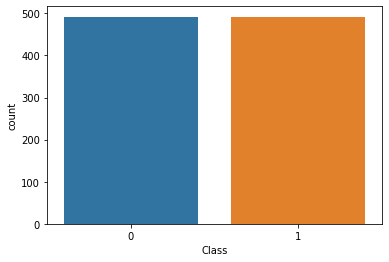

In [ ]:
sns.countplot("Class",data=undersampled_data)

In [ ]:
undersampled_data = spark_sql.createDataFrame(undersampled_data.sample(frac=1))

In [ ]:
train_df,test_df = undersampled_data.randomSplit([0.85, 0.15])

# Build and Train Model

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
from pyspark.ml.linalg import DenseVector,Vectors
from pyspark.ml.feature import StandardScaler

from sklearn.metrics import f1_score, accuracy_score

In [ ]:
stages = []
assembler = VectorAssembler(inputCols=features,outputCol="features")
scaler = StandardScaler(inputCol=assembler.getOutputCol() ,outputCol="ScaledFeatures")
stages += [assembler,scaler]

In [ ]:
pipeline = Pipeline().setStages(stages)
piplelineModel = pipeline.fit(train_df)

train_df = piplelineModel.transform(train_df)

test_df = piplelineModel.transform(test_df)

In [ ]:
train_df = train_df.withColumnRenamed("Class","label")
test_df = test_df.withColumnRenamed("Class","label")

In [ ]:
gbt = RandomForestClassifier(featuresCol="ScaledFeatures",maxDepth=9,numTrees=6,minInstancesPerNode=6)
model = gbt.fit(train_df)
predictions_pd = model.transform(test_df).toPandas()
model_f1_score = f1_score(predictions_pd.label,predictions_pd.prediction)
model_accuracy_score = accuracy_score(predictions_pd.label,predictions_pd.prediction)
print(" F1 score: ",model_f1_score)
print(" Accuracy: ",model_accuracy_score)

 F1 score:  0.9673202614379085
 Accuracy:  0.9640287769784173
